# 企業の財務データの時間変化を見る
このページの日英訳は以下のサイトのものを参考しつつ作成していますが、正確性に欠ける可能性があるのであくまで参考程度にお願い致します。

[TOMAコンサルタンツグループ株式会社 海外決算書の科目　英語→日本語簡易対訳　損益計算書編](https://toma.co.jp/blog/overseas/%e6%b5%b7%e5%a4%96%e6%b1%ba%e7%ae%97%e6%9b%b8%e3%81%ae%e7%a7%91%e7%9b%ae%e3%80%80%e8%8b%b1%e8%aa%9e%e2%86%92%e6%97%a5%e6%9c%ac%e8%aa%9e%e7%b0%a1%e6%98%93%e5%af%be%e8%a8%b3%e3%80%80%e6%90%8d%e7%9b%8a/)

In [1]:
import numpy as np
import pandas as pd
import re

# 英日辞書
en_US_ja_JP_table = {
    "Revenue": "売上",
    "Cost of revenue": "収益コスト",
    "Gross profit": "粗利益",
    "Sales, General and administrative": "販売費及び一般管理費",
    "Other operating expenses": "その他営業費用",
    "Total operating expenses": "営業費用",
    "Operating income": "営業利益",
    "Interest Expense": "支払利息",
    "Other income (expense)": "Other income (expense)",
    "Income before taxes": "Income before taxes",
    "Provision for income taxes": "Provision for income taxes",
    "Net income from continuing operations": "Net income from continuing operations",
    "Net income available to common shareholders": "普通株式に係る当期純利益",
    "Net income": "当期純利益",
    "Basic": "Basic",
    "Diluted": "Diluted",
    "EBITDA": "EBITDA",
    "Revenue ": "売上",
    "Gross Margin %": "	売上総利益率",
    "Operating Income ": "営業利益",
    "Operating Margin %": "営業利益率",
    "Net Income ": "純利益",
    "Earnings Per Share USD": "EPS (USD)",
    "Dividends USD": "配当 (USD)",
    "Payout Ratio % *": "配当性向",
    "Shares Mil": "株数 (Mil)",
    "Book Value Per Share * USD": "1株あたり純資産",
    "Operating Cash Flow ": "営業キャッシュフロー",
    "Cap Spending ": "資本的支出",
    "Free Cash Flow ": "フリーキャッシュフロー（FCF）",
    "Free Cash Flow Per Share * USD": "1株あたりFCF",
    "Working Capital ": "運転資本",
    "Key Ratios -> Profitability": "",
    "Margins % of Sales": "Margins % of Sales",
    "COGS": "売上原価",
    "Gross Margin": "売上高総利益率",
    "SG&A": "販売費及び一般管理費",
    "R&D": "研究開発費",
    "Operating Margin": "営業利益率",
    "Net Int Inc & Other": "資金運用利益+その他",
    "EBT Margin": "EBTマージン",
    "Debt/Equity": "負債比率",
    "Receivables Turnover": "売上債権回転率",
    "Inventory Turnover": "棚卸資産回転率",
    "Fixed Assets Turnover": "固定資産回転率",
    "Asset Turnover": "総資産回転率",
    "USD Mil": "(USD Mil)",
    "-Year Average": "年平均",
}


def get_preprocessed_df(filepath, is_transpose=True, ttm_datetime="2021-12"):
    """Morningstar, Incのデータを整形する

    Args:
        filepath (str): ファイルパス
        is_transpose (bool, optional): タイムスタンプ列を縦にするかどうか. Defaults to True.
        ttm_datetime (str, optional): 「TTM」をどの日付に置き換えるか. Defaults to "2021-12".

    Returns:
        DataFrame: 整形済みデータフレーム
    """
    df_preprocessed = []
    df_header = []
    row_header = ""
    df = pd.read_table(filepath, header=None)
    print(f"[Note] TTM は {ttm_datetime} の日付として扱われます。")

    for idx, row in enumerate(df[0]):
        # 英語を対応する日本語に置き換える
        for str_en, str_jp in en_US_ja_JP_table.items():
            if str_en in row:
                row = row.replace(str_en, str_jp)

        # TTMがある行はタイムスタンプなのでヘッダー扱いにする
        if "TTM" in row:
            row = row.replace("TTM", ttm_datetime)
            df_header = row.split(",")

            if is_transpose:
                df_header[0] = "月"
            else:
                df_header = ["月"] + df_header
            continue

        # 数値に変換できるデータは数値に変換してDataFrameに追加
        if len(row_splited := row.split(",")) > 1:
            row_data = [
                float(v) if re.match(r"^-?\d+(?:\.\d+)$", v) is not None else v
                for v in row_splited
            ]

            if is_transpose:
                row_data[0] = (
                    f"{row_header}/{row_data[0]}" if row_header else f"{row_data[0]}"
                )
            else:
                row_data = [row_header] + row_data
            df_preprocessed.append(row_data)
        else:
            # 　先頭の行はファイルのタイトルが入っているので無視
            row_header = f"{row}" if idx > 0 else ""

    # データフレーム作成
    df_preprocessed = pd.DataFrame(df_preprocessed)
    df_preprocessed.columns = df_header

    # 不要な文字列を削除
    df_preprocessed.fillna(np.nan, inplace=True)

    if is_transpose:
        df_preprocessed = df_preprocessed.T.reset_index()
        df_preprocessed.columns = df_preprocessed.iloc[0, :]
        df_preprocessed.drop(0, inplace=True)
        df_preprocessed["月"] = pd.to_datetime(df_preprocessed["月"])

    return df_preprocessed

## データを読み込む
[Morningstar, Inc](https://www.morningstar.com/)社から提供されているデータを使用します。
このサイトで、指定した企業の財務情報をまとめたcsvファイルを取得します。ここの例では[Golden Ocean Group Ltd](https://www.morningstar.com/stocks/xnas/gogl/quote)のデータを使用しています。

In [2]:
df_is = get_preprocessed_df("data/GOGL Income Statement.csv")
df_kr = get_preprocessed_df("data/GOGL Key Ratios.csv")

from IPython.core.display import display

display(df_is.head())
display(df_kr.head())

[Note] TTM は 2021-12 の日付として扱われます。
[Note] TTM は 2021-12 の日付として扱われます。


,月,売上,収益コスト,粗利益,Operating expenses/販売費及び一般管理費,Operating expenses/その他営業費用,Operating expenses/営業費用,Operating expenses/営業利益,Operating expenses/支払利息,Operating expenses/Other income (expense),Operating expenses/Income before taxes,Operating expenses/Provision for income taxes,Operating expenses/当期純利益 from continuing operations,Operating expenses/当期純利益,Operating expenses/普通株式に係る当期純利益,Earnings per share/Basic,Earnings per share/Diluted,Weighted average shares outstanding/Basic,Weighted average shares outstanding/Diluted,Weighted average shares outstanding/EBITDA
1,2016-12-01,258,313,-55,13,2,15,-70,42,-16,-128,-0,-128,-128,-128,-1.34,-1.34,95,95,-22
2,2017-12-01,460,400,60,13,-4,9,51,57,3,-2,0,-2,-2,-2,-0.02,-0.02,125,125,133
3,2018-12-01,656,499,158,15,-3,12,146,73,12,85,0,85,85,85,0.59,0.59,144,144,250
4,2019-12-01,706,590,116,14,1,15,101,57,-6,37,0,37,37,37,0.26,0.26,144,144,188
5,2020-12-01,608,564,44,14,-3,11,33,45,-126,-138,0,-138,-138,-138,-0.96,-0.96,143,143,18


,月,Financials/売上 (USD Mil),Financials/\t売上総利益率,Financials/営業利益(USD Mil),Financials/営業利益率,Financials/純利益(USD Mil),Financials/EPS (USD),Financials/配当 (USD),Financials/配当性向,Financials/株数 (Mil),...,Key Ratios -> Financial Health/Financial Leverage,Key Ratios -> Financial Health/負債比率,Key Ratios -> Efficiency Ratios/Days Sales Outstanding,Key Ratios -> Efficiency Ratios/Days Inventory,Key Ratios -> Efficiency Ratios/Payables Period,Key Ratios -> Efficiency Ratios/Cash Conversion Cycle,Key Ratios -> Efficiency Ratios/売上債権回転率,Key Ratios -> Efficiency Ratios/棚卸資産回転率,Key Ratios -> Efficiency Ratios/固定資産回転率,Key Ratios -> Efficiency Ratios/総資産回転率
1,2011-12-01,95,68.2,38,40.4,33,6.12,9.0,,5,...,1.45,0.42,18.79,32.12,36.01,14.89,19.43,11.36,0.21,0.18
2,2012-12-01,37,38.2,10,26.8,-53,-10.08,5.4,488.7,5,...,1.43,0.39,48.04,39.37,26.39,61.02,7.6,9.27,0.11,0.08
3,2013-12-01,38,31.3,7,18.2,-4,-0.69,3.15,,6,...,1.33,0.3,26.25,20.6,19.16,27.68,13.91,17.72,0.13,0.09
4,2014-12-01,97,25.4,19,20.1,16,1.38,2.81,184.2,11,...,1.42,0.39,11.45,37.85,16.1,33.2,31.88,9.64,0.13,0.12
5,2015-12-01,190,-28.6,-72,-37.6,-221,-7.3,,,30,...,1.88,0.8,11.9,21.19,5.57,27.51,30.68,17.22,0.13,0.11


## 変化を可視化する
seabornを使ってグラフを作成してみます。

```{hint}
[seaborn.barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html)
```

<AxesSubplot:xlabel='月', ylabel='Financials/配当 (USD)'>

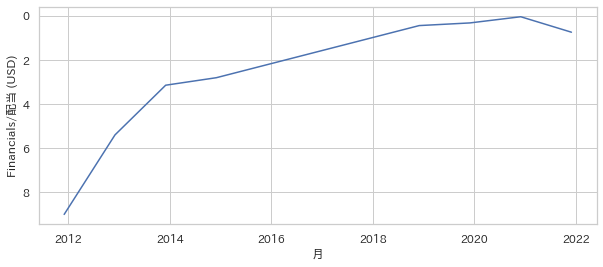

In [3]:
import seaborn as sns
import japanize_matplotlib

sns.set_theme(style="whitegrid", rc={"figure.figsize": (10, 4)})
japanize_matplotlib.japanize()

sns.lineplot(data=df_kr, x="月", y="Financials/配当 (USD)")